# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Get the data from the file [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).


- Create a dataframe `df` with the columns: `date`, `am`, `pm`, `target`, where `date` is the date of the day, `am` is the number of the commits during the day before midday (integer), `pm` is the number of commits during the day after midday (integer), `target` is weekend/working_day.

- Получите данные из файла [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).

- Создайте фрейм данных `df` со столбцами: `date`, `am`, `pm`, `target`, где `date` - дата дня, `am` - количество коммитов в течение дня до полудня (целое число), `pm` - количество коммитов в течение дня после полудня (целое число), `target` - выходные/рабочие_дни.

In [2]:
df = pd.read_csv('../data/checker_timestamp.csv', header=None, names=['timestamp'], skiprows=1)
print(df.head()) 
print(df.dtypes)  
df['timestamp'] = pd.to_datetime(df['timestamp'])

                    timestamp
0  2020-04-17 05:19:02.744528
1  2020-04-17 05:22:35.249331
2  2020-04-17 05:22:45.549397
3  2020-04-17 05:34:14.691200
4  2020-04-17 05:34:24.422370
timestamp    object
dtype: object


In [3]:
df['date'] = df['timestamp'].dt.date

In [4]:
df['is_weekend'] = df['timestamp'].dt.weekday >= 5

In [5]:
df['is_am'] = df['timestamp'].dt.hour < 12
daily_counts = df.groupby('date').agg(
    am=('is_am', 'sum'),
    pm=('is_am', lambda x: len(x) - sum(x))
).reset_index()

In [6]:
daily_counts['weekday'] = pd.to_datetime(daily_counts['date']).dt.weekday
daily_counts['target'] = daily_counts['weekday'].apply(
    lambda x: 'weekend' if x >= 5 else 'working_day'
)

In [7]:
df_final = daily_counts[['date', 'am', 'pm', 'target']].copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3207 entries, 0 to 3206
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   3207 non-null   datetime64[ns]
 1   date        3207 non-null   object        
 2   is_weekend  3207 non-null   bool          
 3   is_am       3207 non-null   bool          
dtypes: bool(2), datetime64[ns](1), object(1)
memory usage: 56.5+ KB


In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    35 non-null     object
 1   am      35 non-null     int64 
 2   pm      35 non-null     int64 
 3   target  35 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.2+ KB


## 2. Exploratory analysis

- Create a plot where `x` is am, `y` is pm, each dot is a day, working days and weekends must have different colors.


- By looking at the graph do you think it will be easy to classify the days having those two features? Put your answer in the markdown cell in the end of that sectioin: "yes, it is easy" or "no, it is not easy".

- Создайте график, где `x` - это am, `y` - pm, каждая точка - это день, рабочие дни и выходные должны быть разного цвета.

- Глядя на график, как вы думаете, будет ли легко классифицировать дни, имеющие эти две особенности? Введите свой ответ в ячейку разметки в конце этого раздела: «да, это легко» или «нет, это нелегко».

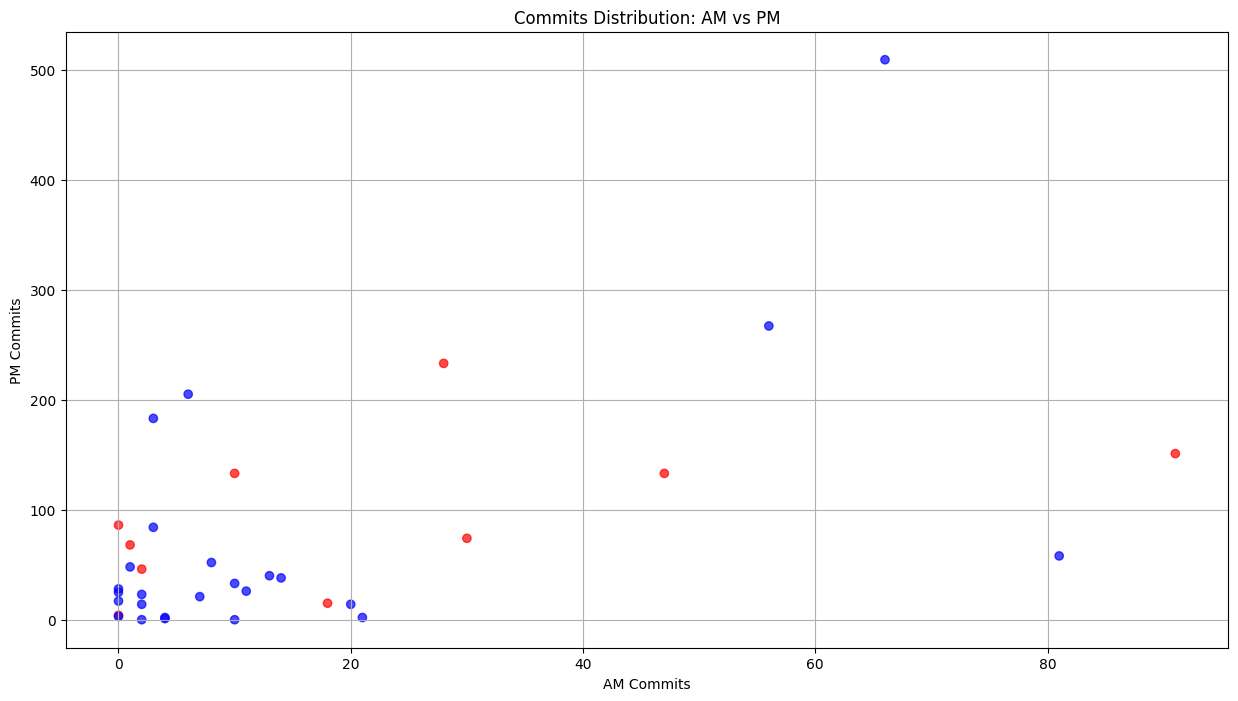

In [10]:
plt.figure(figsize=(15, 8))
colors = df_final['target'].map({
    'weekend': 'red', 
    'working_day': 'blue'
})
plt.scatter(df_final['am'], df_final['pm'], c=colors, alpha=0.7)
plt.xlabel('AM Commits')
plt.ylabel('PM Commits')
plt.title('Commits Distribution: AM vs PM')
plt.grid(True)
plt.show()

Глядя на график, нелегко классифицировать дни, используя только утренние и вечерние коммиты. 
Рабочие дни и выходные имеют перекрывающиеся шаблоны коммитов, что затрудняет четкое разделение.

## 3. Logistic regression

- Train logistic regression on your data using `am` and `pm`, parameters are: `random state=21`, `fit_intercept=False`.


- Make predictions for every day of your dataset and add them to your dataframe with the column name `predict`.


- Save the dataframe into a file in the subfolder of the day `data` with the name `am_pm.csv`.


- Draw another plot like you did before, but the color should be taken from the `predict`.


- By looking at the graph do you think if it made good predictions? Put your answer in the markdown cell in the end of that section: "yes, it is good"; "no, it is not good".

- Обучите логистическую регрессию на ваших данных, используя `am` и `pm`, параметры: `random state=21`, `fit_intercept=False`.

- Сделайте прогнозы для каждого дня вашего набора данных и добавьте их в ваш фрейм данных с именем столбца `predict`.

- Сохраните фрейм данных в файле в подпапке дня `data` с именем `am_pm.csv`.

- Нарисуйте еще один график, как вы делали раньше, но цвет должен быть взят из `predict`.

- Глядя на график, как вы думаете, сделал ли он хорошие прогнозы? Вставьте свой ответ в ячейку markdown в конце этого раздела: «да, это хорошо»; «нет, это не хорошо».

In [11]:
X = df_final[['am', 'pm']]
le = LabelEncoder()
y = le.fit_transform(df_final['target']) 

# Train model
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(X, y)

# Make predictions
df_final['predict'] = le.inverse_transform(model.predict(X))

# Save results
df_final.to_csv('../data/am_pm.csv', index=False)

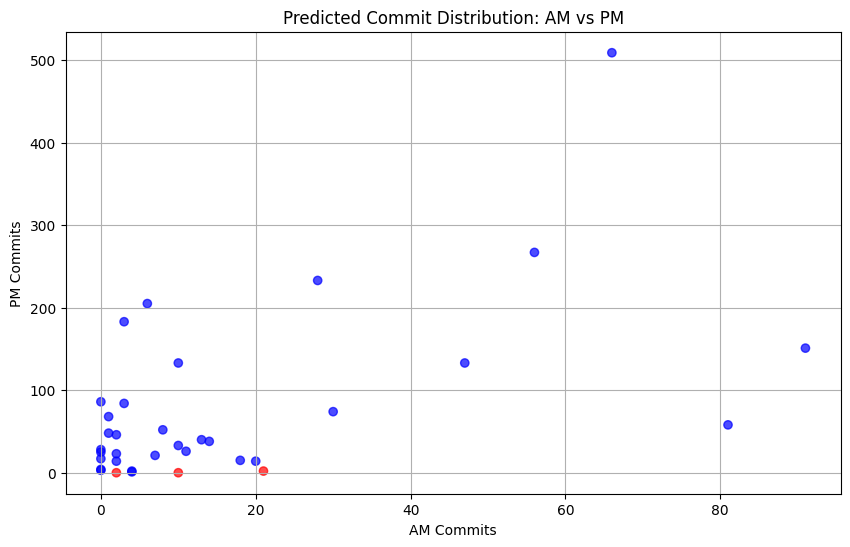

In [12]:
plt.figure(figsize=(10, 6))
colors = df_final['predict'].map({
    'weekend': 'red', 
    'working_day': 'blue'
})
plt.scatter(df_final['am'], df_final['pm'], c=colors, alpha=0.7)
plt.xlabel('AM Commits')
plt.ylabel('PM Commits')
plt.title('Predicted Commit Distribution: AM vs PM')
plt.grid(True)
plt.show()

Модель с трудом точно классифицирует выходные и рабочие дни, 
со множеством неправильно классифицированных точек в перекрывающихся областях.

## 4. Evaluation

- Calculate `accuracy` for your predictions.


- Calculate `accuracy` for the naive case when each of your prediction is the value of your most popular class of the day.


- Comparing the accuracies do you think that the classifier made good predictions? Put your answer in the markdown cell in the end of the secion: "yes, it is good"; "no, it is not good".

- Рассчитайте `точность` для ваших прогнозов.

- Рассчитайте `точность` для наивного случая, когда каждое из ваших прогнозов является значением вашего самого популярного класса дня.

- Сравнивая точности, считаете ли вы, что классификатор сделал хорошие прогнозы? Введите свой ответ в ячейку уценки в конце раздела: "да, это хорошо"; "нет, это не хорошо".

In [13]:
y_true = df_final['target']
y_pred = df_final['predict']
accuracy = accuracy_score(y_true, y_pred)

# Calculate naive accuracy 
majority_class = df_final['target'].mode()[0]
naive_accuracy = accuracy_score(y_true, [majority_class]*len(y_true))

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Naive Accuracy: {naive_accuracy:.4f}")

Model Accuracy: 0.6286
Naive Accuracy: 0.7143


Точность модели лишь незначительно лучше, чем у наивного классификатора, 
что указывает на плохую предсказательную эффективность для этой задачи.